#### Motivated by a paper by Andrew Gelman et al. http://www.stat.columbia.edu/~gelman/research/unpublished/bayes_R2.pdf 

In this notebook, we will demonstrate a modified version of $R^2$ that is more suitable for Bayesian regression. 

The basic definiton of $R^2$ is:

$
R^2 \equiv \dfrac{\text{variance of the predicted values}}{\text{variance of the data}}
$

The classical $R^2$ is defined as:

$
R^2 \equiv \dfrac{\text{estimated variance}}{\text{total variance}} = \dfrac{\sum\limits_{i}^{N} (\hat{y}^{(i)} - \bar{\hat{y}})^2}{\sum\limits_{i}^{N} (y^{(i)} - \bar{y})^2} = \dfrac{ESS}{TSS} = \dfrac{TSS - RSS}{TSS} = 1 - \dfrac{RSS}{TSS}
$

where 

\begin{array}
 \text{TSS} &=& \text{Total Sum of Squares} = \sum\limits_{i}^{N} (y^{(i)} - \bar{y})^2 \\
 \text{ESS} &=& \text{Estimated Sum of Squares} = \sum\limits_{i}^{N} (\hat{y}^{(i)} - \bar{\hat{y}})^2 \\
 \text{RSS} &=& \text{Residual Sum of Squares} = \sum\limits_{i}^{N} \epsilon^{(i)^2} =  \sum\limits_{i}^{N} (y^{(i)} - \hat{y^{(i)}})^2
\end{array}



- In ordinary least square (OLS) fit, by construction, $y^{(i)} = \hat{y^{(i)}} + \epsilon^{(i)}$, and consequently $TSS = ESS + RSS$, where


\begin{array}
 \text{TSS} &=& \text{Total Sum of Squares} = \sum\limits_{i}^{N} (y^{(i)} - \bar{y})^2 \\
 \text{ESS} &=& \text{Estimated Sum of Squares} = \sum\limits_{i}^{N} (\hat{y}^{(i)} - \bar{\hat{y}})^2 \\
 \text{RSS} &=& \text{Residual Sum of Squares} = \sum\limits_{i}^{N} \epsilon^{(i)^2} =  \sum\limits_{i}^{N} (y^{(i)} - \hat{y^{(i)}})^2
\end{array}

so $R^2$ can be written as:

$
\text{classical } R^2 =\dfrac{\text{estimated variance}}{\text{total variance}} = \dfrac{\sum\limits_{i}^{N} (\hat{y}^{(i)} - \bar{\hat{y}})^2}{\sum\limits_{i}^{N} (y^{(i)} - \bar{y})^2} = \dfrac{ESS}{TSS} = \dfrac{TSS - RSS}{TSS} = 1 - \dfrac{RSS}{TSS}
$



- However, in Bayesian regression, there is no restriction on ESS as to its value relative to TSS. To see why, recall that the formulation for Bayesian regression:

$
y^{(i)} \sim \mathcal{N}(x^{(i)^T} \beta, \sigma^2)
$

where $\beta$ and $\sigma$ are drawn from some user-specified prior distributions.

Therefore, a more appropriate definiton of $R^2$ will be the following:

$
\text{alternative } R^2 \equiv \dfrac{\sum\limits_{i}^{N} (\hat{y}^{(i)} - \bar{\hat{y}})^2}{\sum\limits_{i}^{N} (\hat{y}^{(i)} - \bar{\hat{y}})^2 + \sum\limits_{i}^{N} \epsilon^{(i)^2}} = \dfrac{ESS}{ESS + RSS}
$

Noteice that the above definiton of $R^2$ has the following properties:

1) It's guaranteed to be between 0 and 1

2) When applied to OLS model, it's exactly the same as classical $R^2$ as TSS = ESS + RSS in OLS.

In [118]:
import numpy as np
import pandas as pd
import patsy
import statsmodels.api as sm
import pymc3 as pm
import scipy.stats

import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [6]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

In [4]:
def generateData(true_intercept=1, true_slope=2, noise=0.5, n_points=20):
    df = pd.DataFrame({'x': np.random.uniform(-2.3, 2.3, size=n_points)})
    df['y'] = true_intercept + true_slope * df['x'] + np.random.np.random.normal(0, scale=noise, size=n_points)
    df = df.sort_values(['x'], ascending=True).reset_index(drop=True)
    return df

# Generate data

In [29]:
true_intercept = 1
true_slope = 2
noise = 1
n_points = 20
data = generateData(true_intercept, true_slope, noise, n_points)

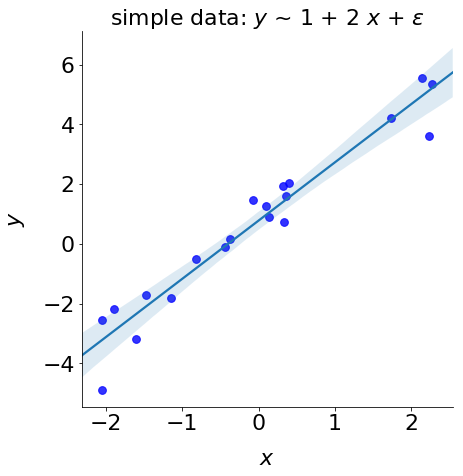

In [30]:
FONTSIZE = 22
g = sbn.lmplot(x='x', y='y', data=data, fit_reg=True, 
               size=6, scatter_kws={'alpha':0.8, 's':60, 'color': 'b'})

_ = g.axes.flat[0].set_xlabel(r'$x$', fontsize=FONTSIZE, labelpad=15)
_ = g.axes.flat[0].set_ylabel(r'$y$', fontsize=FONTSIZE, labelpad=15)
g.axes.flat[0].set_title(r'simple data: $y$ ~ {0:} + {1:} $x$ + $\epsilon$'.format(true_intercept, true_slope), 
                         fontsize=FONTSIZE)
adjustAxeProperties(g.axes.flat[0], FONTSIZE, 0, FONTSIZE, 0)

# Fit a ordinary least sqaure (OLS) / linear regression model 

In [31]:
formula = 'y ~ x'
(y, X) = patsy.dmatrices(formula, data, return_type='dataframe')
lin_reg = sm.OLS(y, X).fit()

In [32]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     271.1
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           2.68e-12
Time:                        14:59:34   Log-Likelihood:                -20.821
No. Observations:                  20   AIC:                             45.64
Df Residuals:                      18   BIC:                             47.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7770      0.162      4.799      0.000       0.437       1.117
x              1.9485      0.118     16.466      0.000       1.700       2.197
==============================================================================
Omnibus:                        6.484   Durbin-Watson:                   2.365
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                4.471
Skew:                          -1.136   Prob(JB):                        0.107
Kurtosis:                       3.452   Cond. No.                         1.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
def classical_R2(y_true, y_pred, axis=None):
    # y_pred: n_draws x n_data_points
    if axis is not None:
        y_true = np.reshape(y_true, (1, len(y_true)))
        return np.var(y_pred, axis=axis) / np.var(y_true, axis=axis) 
    else:
        return np.var(y_pred) / np.var(y_true)

def alternative_R2(y_true, y_pred, axis=None)    :
    if axis is not None:
        y_true = np.reshape(y_true, (1, len(y_true)))
        r = y_true - y_pred
        return np.var(y_pred, axis=axis) / (np.var(y_pred, axis=axis) + np.var(r, axis=axis))
    else:
        r = y_true - y_pred
        return np.var(y_pred) / (np.var(y_pred) + np.var(r))

In [72]:
classical_r2 = classical_R2(data['y'].values, lin_reg.predict(X))
print('classical R2: {0:.3f}'.format(classical_r2))

alternative_r2 = alternative_R2(data['y'].values, lin_reg.predict(X))
print('alternative R2: {0:.3f}'.format(alternative_r2))


classical R2: 0.938
alternative R2: 0.938


The $R^2$ is 0.938, consistent with statsmodels output. We also verify that for OLS, the classical $R^2$ and the alternative $R^2$ are the same. 

# Bayesian linear regression and $R^2$

Let's fit a Bayesian linear regression model

In [193]:
xvals = data['x'].values
yvals = data['y'].values
with pm.Model() as model:
    
    BURN_IN_STEPS = 2000
    MCMC_STEPS = 4000
    
    # Specify priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)    
    beta0 = pm.Normal('beta0', 0.0, sd=10.0)
    beta1 = pm.Normal('beta1', 0.0, sd=10.0)
    
    # Specify likelihood
    likelihood = pm.Normal('y', mu=beta0 + beta1 * xvals, sd=sigma,
                           observed=yvals)
    
    # MCMC 
    start = pm.find_MAP()
    trace = pm.sample(BURN_IN_STEPS+MCMC_STEPS, start=start, step=pm.NUTS())
    trace = trace[BURN_IN_STEPS:]

# Use posterior predictive check to draw 1000 samples of parameters
posterior_predictive = pm.sample_ppc(trace, model=model, samples=1000, progressbar=False)    

logp = -30.045, ||grad|| = 7.9284e-06: 100%|██████████| 22/22 [00:00<00:00, 2569.47it/s]  
100%|██████████| 6500/6500 [00:05<00:00, 1135.60it/s]


In [194]:
posterior_predictive.keys()

dict_keys(['y'])

In [148]:
# each row corresponds to a given draw of the parameters
# each column corresponds to a data point
posterior_predictive['y'].shape

(1000, 20)

Based on the posterior draws, we can compare the classical $R^2$ and adjusted $R^2$, to see which one better describes a Bayesian linear regression model.

In [195]:
mcmc_classical_R2 = classical_R2(data['y'].values, posterior_predictive['y'], axis=1)
mcmc_Bayesian_R2 = alternative_R2(data['y'].values, posterior_predictive['y'], axis=1)

bayesian_median = np.percentile(mcmc_Bayesian_R2, 50)

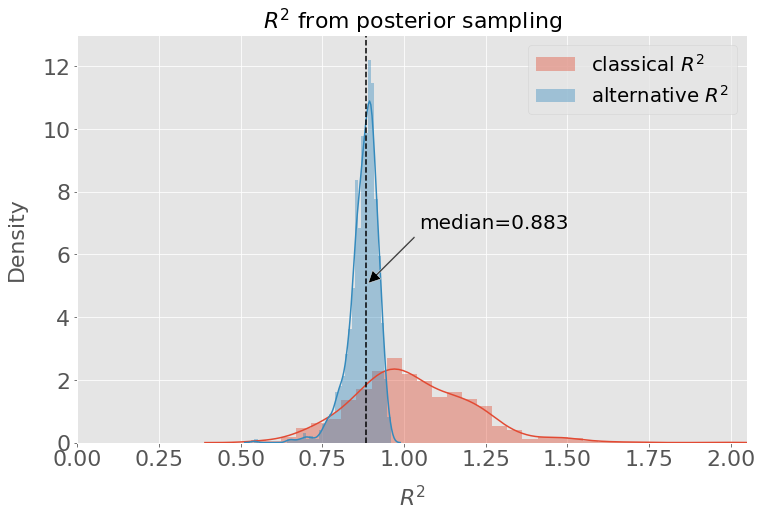

In [199]:
FONTSIZE = 22
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12, 7.5))
ax = sbn.distplot(mcmc_classical_R2, ax=ax, label=r'classical $R^2$')
ax = sbn.distplot(mcmc_Bayesian_R2, ax=ax, label=r'alternative $R^2$')
ax.axvline(bayesian_median, ls='--', color='k')
ax.legend(loc='best', fontsize=FONTSIZE*0.9)
ax.set_title(r'$R^2$ from posterior sampling', fontsize=FONTSIZE)

ax.annotate('median={0:.3f}'.format(bayesian_median),
            xy=(bayesian_median, 5),
            xytext=(0.55, 0.55),
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            horizontalalignment='left',
            verticalalignment='bottom',
            fontsize=20)
ax.set_xlim(0, 2.05)            
ax.set_ylim(0, 13)
ax.set_xlabel(r'$R^2$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Density', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)

Apparently, alternative $R^2$ suits better for the Bayesian linear regression model, as it's always between 0 and 1, while classical $R^2$ can go up to 1.5, awkwardly implying that the model explains 150% of the data.